# Importing pandas and Reading a CSV

In [2]:
import pandas as pd
# Reading CSV
file = "C:/Users/saimi/Downloads/un-general-debates-blueprint.csv"
df = pd.read_csv(file)
df.head()

session  year country country_name             speaker position  \
0       25  1970     ALB      Albania             Mr. NAS      NaN   
1       25  1970     ARG    Argentina  Mr. DE PABLO PARDO      NaN   
2       25  1970     AUS    Australia         Mr. McMAHON      NaN   
3       25  1970     AUT      Austria  Mr. KIRCHSCHLAEGER      NaN   
4       25  1970     BEL      Belgium          Mr. HARMEL      NaN   

                                                text  
0  33: May I first convey to our President the co...  
1  177.\t : It is a fortunate coincidence that pr...  
2  100.\t  It is a pleasure for me to extend to y...  
3  155.\t  May I begin by expressing to Ambassado...  
4  176. No doubt each of us, before coming up to ...

# Printing Multiple Texts

In [3]:
print(repr(df.iloc[2666]["text"][0:400]))
print(repr(df.iloc[4726]["text"][0:400]))

'\ufeffIt is indeed a pleasure for me and the members of my delegation to extend to Ambassador Garba our sincere congratulations on his election to the presidency of the forty-fourth session of the General Assembly. His election to this high office is a well-deserved tribute to his personal qualities and experience. I am fully confident that under his able and wise leadership the Assembly will further c'
'\ufeffI wish to join\nother representatives in congratulating you, Sir, on\nyour unanimous election as President of the fifty-sixth\nsession of the General Assembly. We are confident that\n27\n\nunder your able guidance the work of this General\nAssembly session will be another milestone on the new\ninternational scene, particularly in confronting the new\nchallenges facing our world, especially after the\nextre'


# Spliting Speech into a Sentence

In [4]:
import re

df["paragraphs"] = df["text"].map(lambda text: re.split(r'\.\s*\n', text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)


# Importing TFIDF Vectorization

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

# Convert the set of stop words to a list
stopwords_list = list(stopwords)

tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords_list, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape


C:\Users\saimi\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(7507, 24611)

# Creating a DataFrame on Sentences

In [6]:
# flatten the paragraphs keeping the years
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year } 
                               for paragraphs, year in zip(df["paragraphs"], df["year"]) 
                                    for paragraph in paragraphs if paragraph])
paragraph_df.head(10)


text  year
0  33: May I first convey to our President the co...  1970
1  35.\tThe utilization of the United Nations to ...  1970
2  36.\tThe whole of progressive mankind recalls ...  1970
3  37.\tAll this has had well known consequences ...  1970
4  38.\tOne of the undeniable proofs that the Uni...  1970
5  39.\tUndoubtedly, such a state of affairs in t...  1970
6  40.\tThe liberation movement at the world leve...  1970
7  41.\tPanic-stricken at the impetuous growth of...  1970
8  42.\tAlthough split by numerous contradictions...  1970
9  43.\tIn that connexion we can cite, simultaneo...  1970

# TFIDF DataFrame

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

# Convert the set of stop words to a list
stopwords_list = list(stopwords)

tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords_list, min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
tfidf_para_vectors.shape


C:\Users\saimi\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279076, 25162)

# NMF 

In [8]:
from sklearn.decomposition import NMF

nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

C:\Users\saimi\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


# Displaying Topics

In [9]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  co (0.79)
  operation (0.65)
  disarmament (0.36)
  nuclear (0.34)
  relations (0.25)

Topic 01
  terrorism (0.38)
  challenges (0.32)
  sustainable (0.30)
  millennium (0.29)
  reform (0.28)

Topic 02
  africa (1.15)
  african (0.82)
  south (0.63)
  namibia (0.36)
  delegation (0.30)

Topic 03
  arab (1.02)
  israel (0.89)
  palestinian (0.60)
  lebanon (0.54)
  israeli (0.54)

Topic 04
  american (0.33)
  america (0.31)
  latin (0.31)
  panama (0.21)
  bolivia (0.21)

Topic 05
  pacific (1.55)
  islands (1.23)
  solomon (0.86)
  island (0.82)
  fiji (0.71)

Topic 06
  soviet (0.81)
  republic (0.78)
  nuclear (0.68)
  viet (0.64)
  socialist (0.63)

Topic 07
  guinea (4.26)
  equatorial (1.75)
  bissau (1.53)
  papua (1.47)
  republic (0.57)

Topic 08
  european (0.61)
  europe (0.44)
  cooperation (0.39)
  bosnia (0.34)
  herzegovina (0.30)

Topic 09
  caribbean (0.98)
  small (0.66)
  bahamas (0.63)
  saint (0.63)
  barbados (0.61)


In [10]:
nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())


Topic 00
  nations (5.61)
  united (5.50)
  organization (1.27)
  states (1.02)
  charter (0.93)

Topic 01
  general (2.86)
  session (2.83)
  assembly (2.81)
  mr (1.99)
  president (1.81)

Topic 02
  countries (4.41)
  developing (2.49)
  economic (1.50)
  developed (1.35)
  trade (0.92)

Topic 03
  people (1.36)
  peace (1.33)
  east (1.29)
  middle (1.17)
  palestinian (1.16)

Topic 04
  nuclear (4.93)
  weapons (3.26)
  disarmament (2.01)
  treaty (1.71)
  proliferation (1.46)

Topic 05
  rights (6.48)
  human (6.16)
  respect (1.15)
  fundamental (0.85)
  universal (0.82)

Topic 06
  africa (3.80)
  south (3.30)
  african (1.70)
  namibia (1.38)
  apartheid (1.18)

Topic 07
  security (6.10)
  council (5.87)
  permanent (1.49)
  reform (1.49)
  peace (1.29)

Topic 08
  international (2.03)
  world (1.48)
  community (0.91)
  new (0.76)
  peace (0.67)

Topic 09
  development (4.47)
  sustainable (1.19)
  economic (1.06)
  social (0.99)
  goals (0.94)


# Size Of Topics

In [11]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([11.06189432, 17.0213082 , 13.6565622 , 10.18695452, 11.35821532,
        5.95003141,  7.90001101,  4.13937503, 11.91132462,  6.81432338])

In [12]:
W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0

array([10.42905814, 10.3250673 , 10.19143368,  9.97207971,  6.63847604,
        7.36011502,  8.92422143,  8.31107274, 16.87412537, 10.97435057])

# Count Vectorization

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Reduce the size of the dataset (optional)
paragraph_df_subset = paragraph_df.sample(n=100)  # Adjust the sample size as needed

# Initialize CountVectorizer with English stop words
count_para_vectorizer = CountVectorizer(stop_words='english', min_df=5, max_df=0.7)

# Fit and transform the CountVectorizer on the dataset
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])

# Initialize LatentDirichletAllocation with desired parameters
lda_para_model = LatentDirichletAllocation(n_components=10, random_state=42, n_jobs=-1)  # Utilize multiple CPU cores

# Fit the LDA model to the CountVectorizer output
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)

# Get the topic-word distributions
H_lda_para_matrix = lda_para_model.components_

# Breaking Paras into Words

In [14]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stopwords.words('english')  # Get English stopwords
count_para_vectorizer = CountVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape

(279076, 25325)

# LDA

In [15]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

# Display Topics and Topic Size

In [16]:
# Assuming count_para_vectorizer is properly initialized and fitted
feature_names = count_para_vectorizer.get_feature_names_out()

# Then use the feature names with the display_topics function
display_topics(lda_para_model, feature_names)


Topic 00
  countries (3.68)
  economic (2.55)
  developing (1.64)
  world (1.52)
  development (1.46)

Topic 01
  nations (2.41)
  world (2.30)
  united (1.83)
  us (1.10)
  international (1.08)

Topic 02
  nuclear (2.25)
  weapons (1.66)
  states (1.42)
  disarmament (1.30)
  arms (1.04)

Topic 03
  rights (1.85)
  human (1.79)
  international (1.74)
  nations (1.29)
  united (1.26)

Topic 04
  peace (1.65)
  conflict (1.11)
  war (0.95)
  east (0.89)
  situation (0.86)

Topic 05
  republic (1.80)
  people (1.59)
  government (1.55)
  country (1.51)
  democratic (1.28)

Topic 06
  people (2.46)
  israel (1.23)
  palestinian (1.06)
  arab (1.05)
  right (0.80)

Topic 07
  united (1.96)
  nations (1.81)
  africa (1.71)
  international (1.69)
  south (1.48)

Topic 08
  nations (2.29)
  united (2.21)
  development (1.93)
  international (1.45)
  economic (1.03)

Topic 09
  general (4.56)
  assembly (3.50)
  session (3.16)
  mr (1.89)
  president (1.84)


In [17]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([10.45988782, 17.05369796,  8.09491642, 10.21496207,  9.60402299,
        8.55827569,  7.63327771,  9.66996589, 10.27799008,  8.43300337])

# WorldClouds

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

C:\Users\saimi\AppData\Local\Temp\ipykernel_39996\3253276570.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# NMF WorldClouds

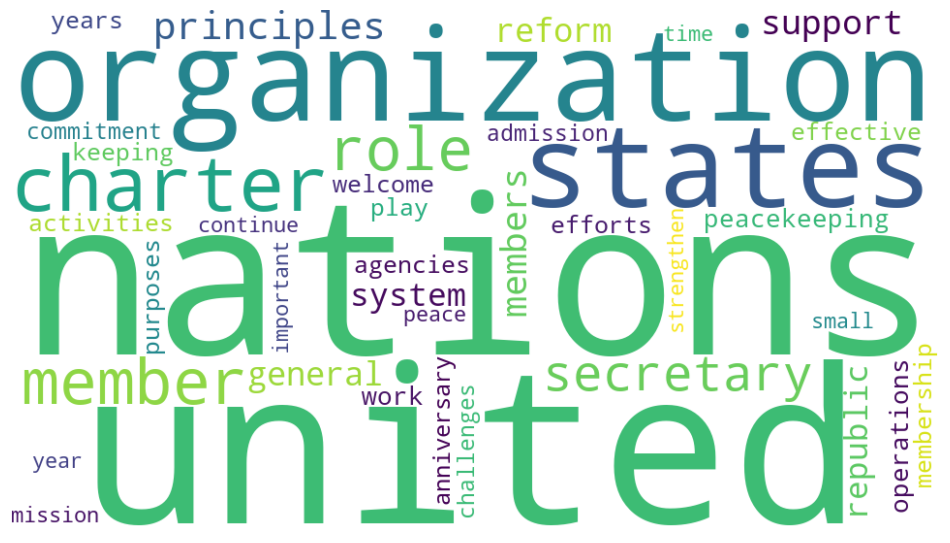

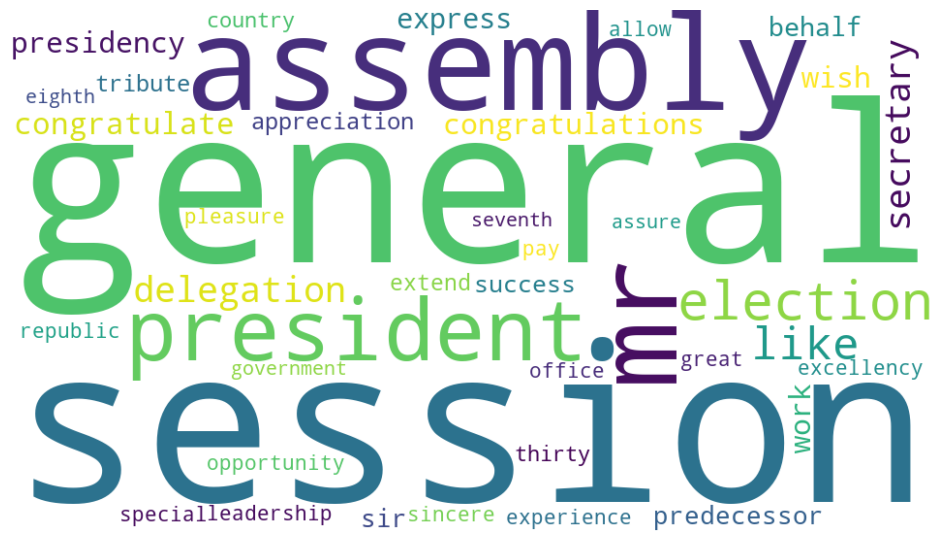

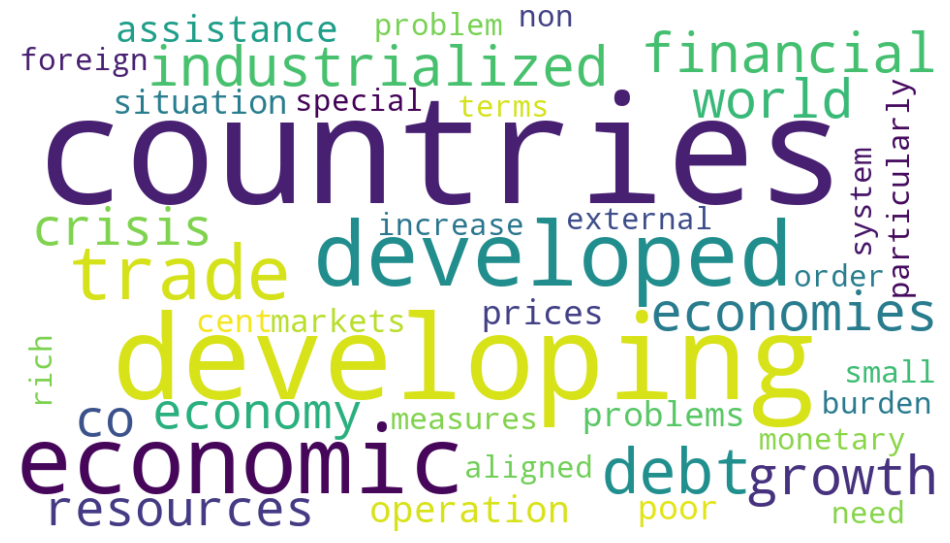

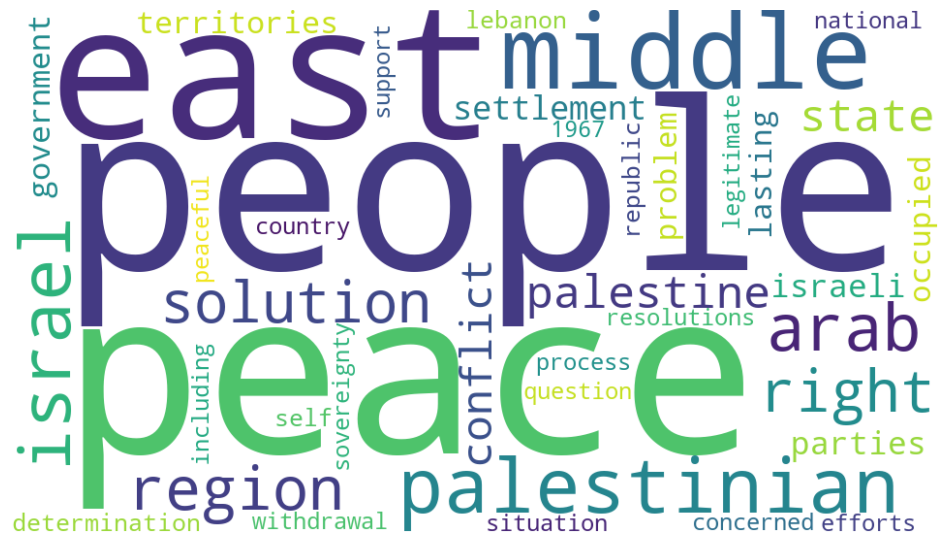

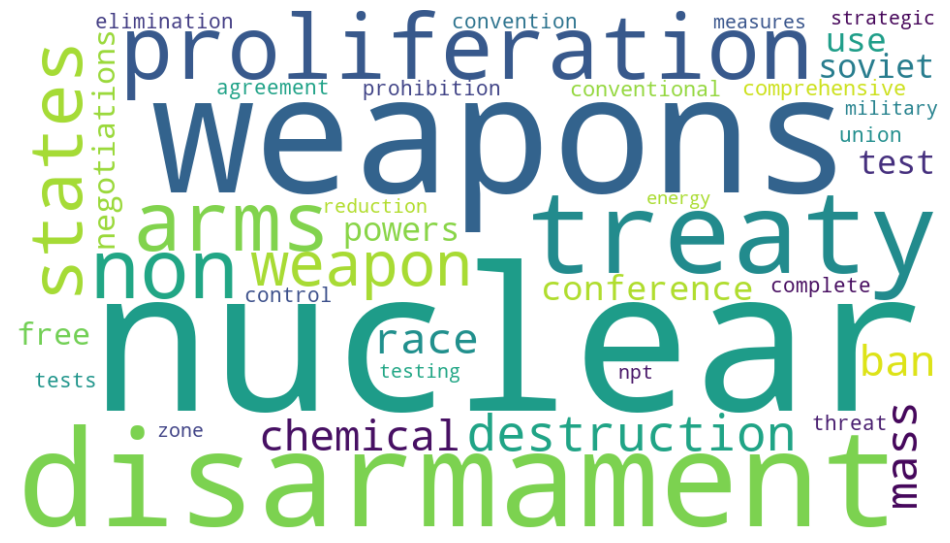

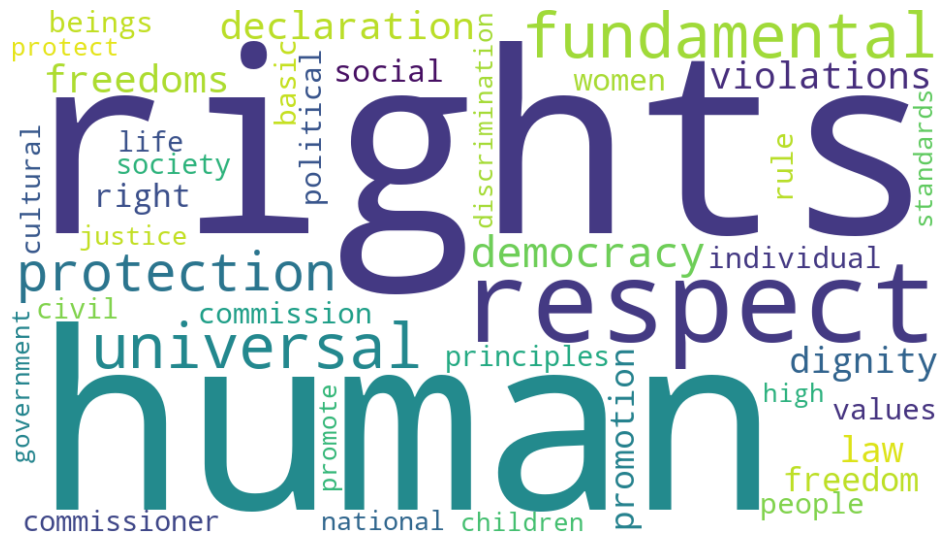

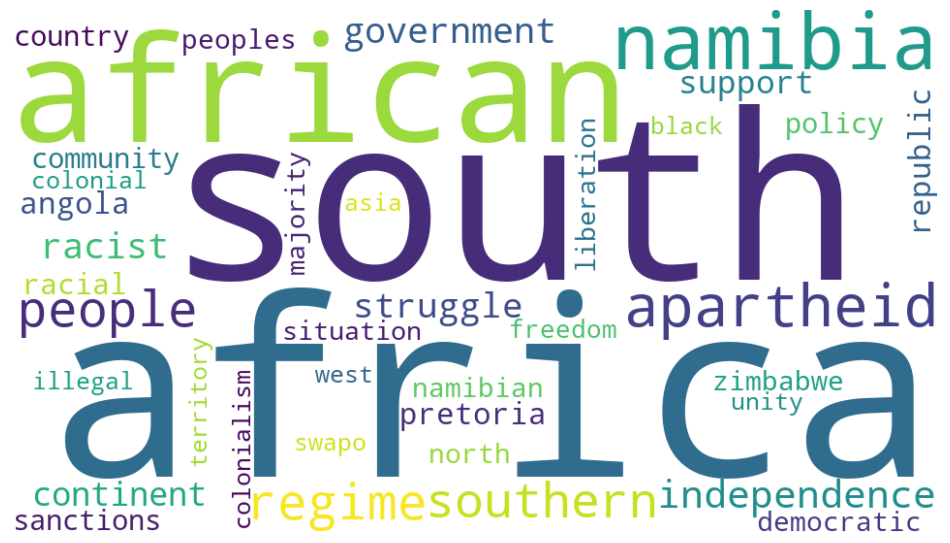

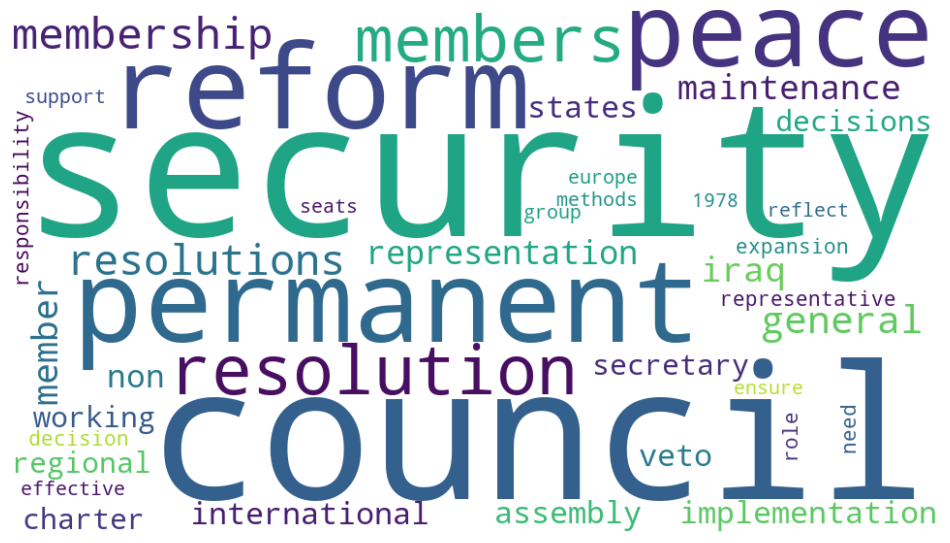

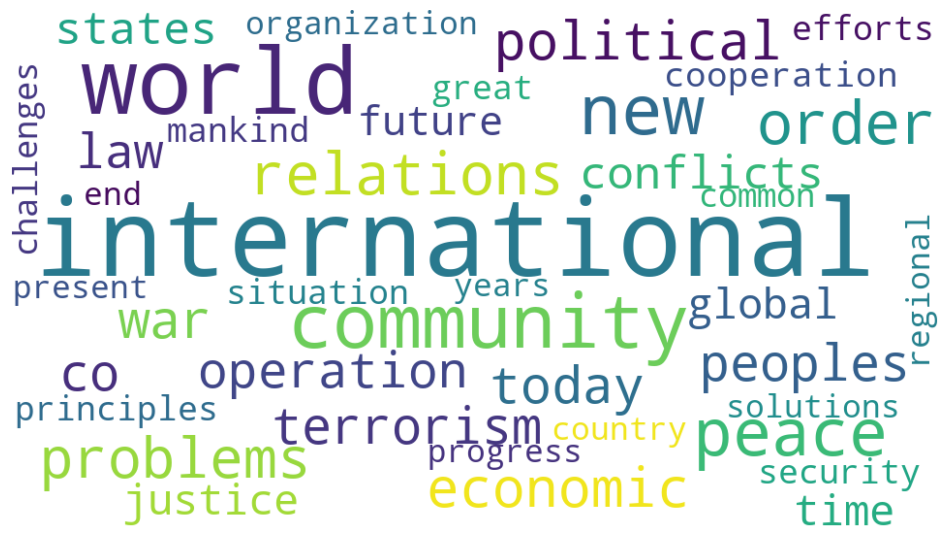

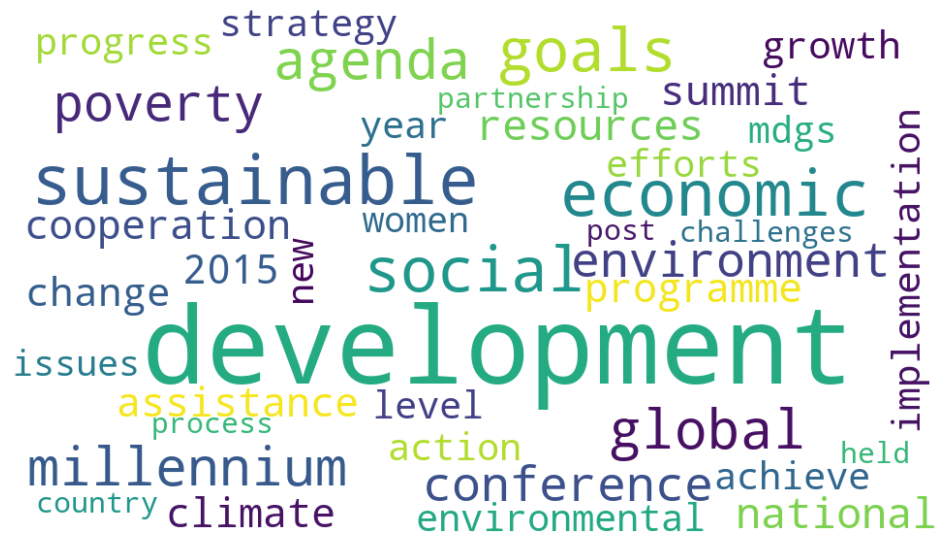

In [25]:
wordcloud_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())

# LDA WorldClouds

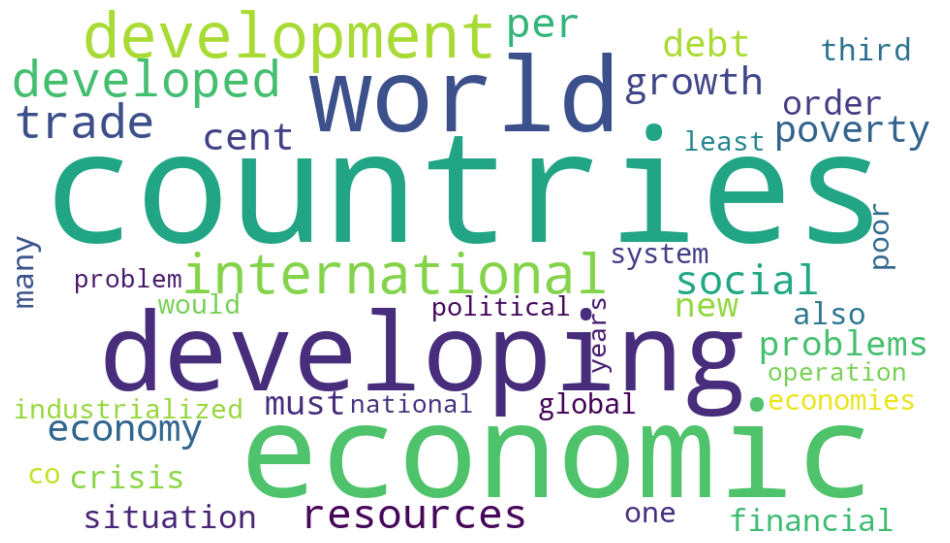

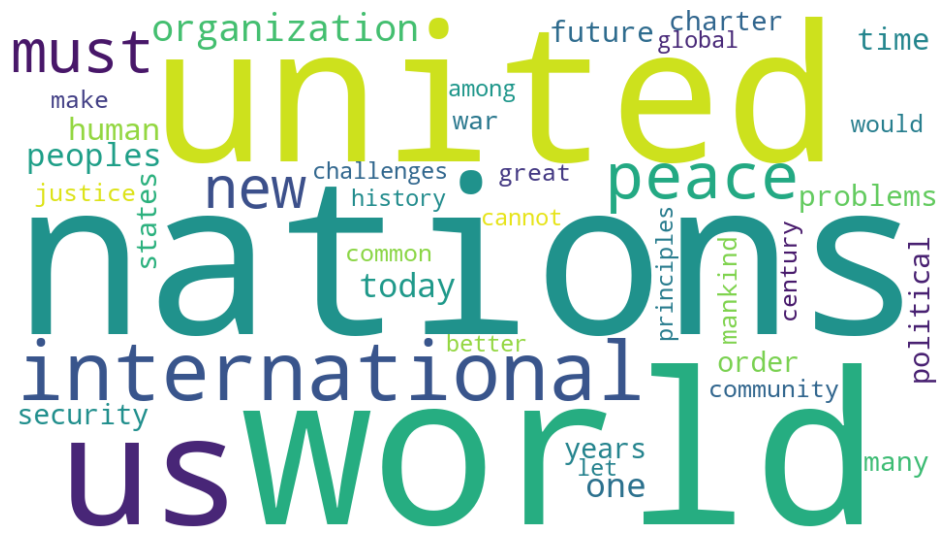

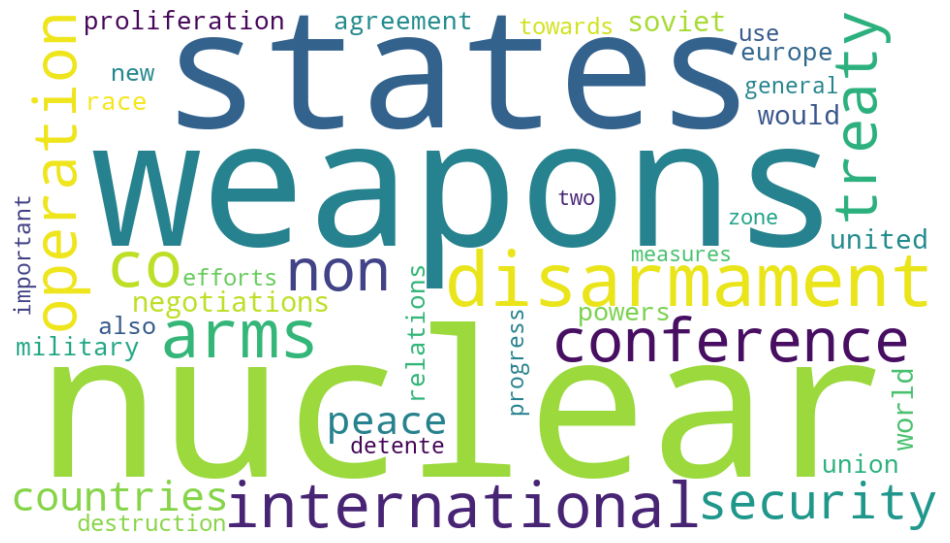

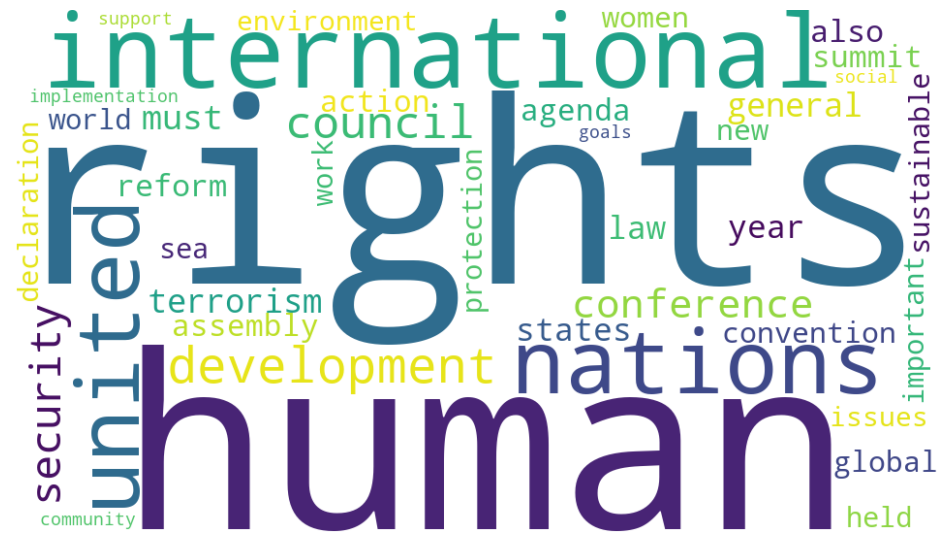

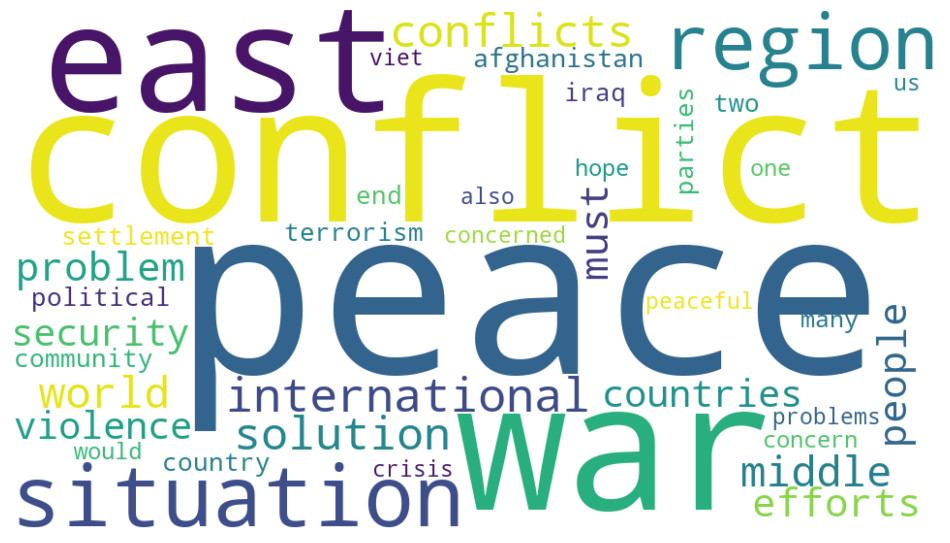

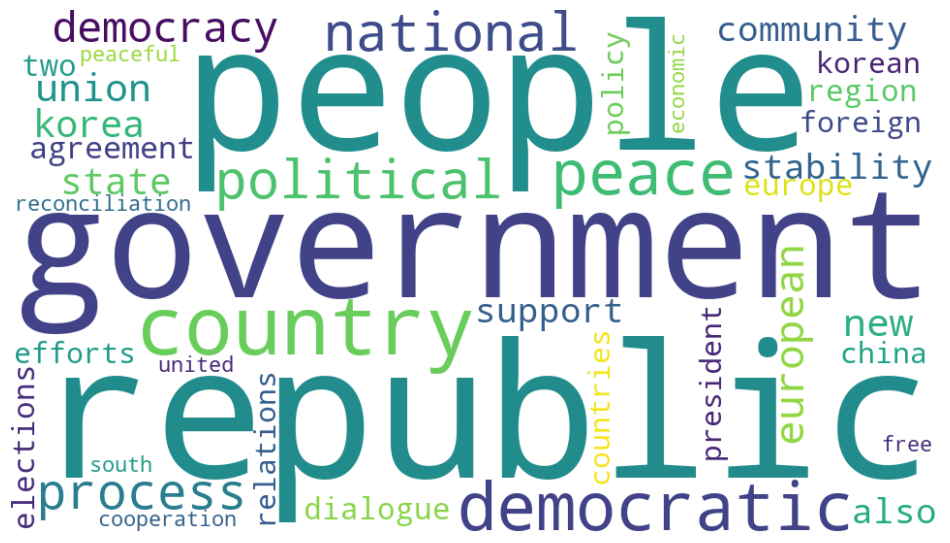

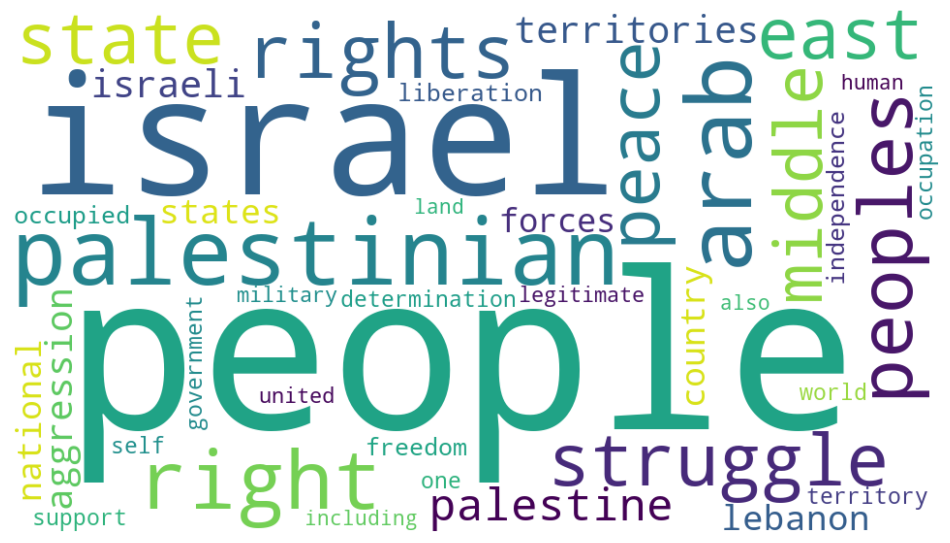

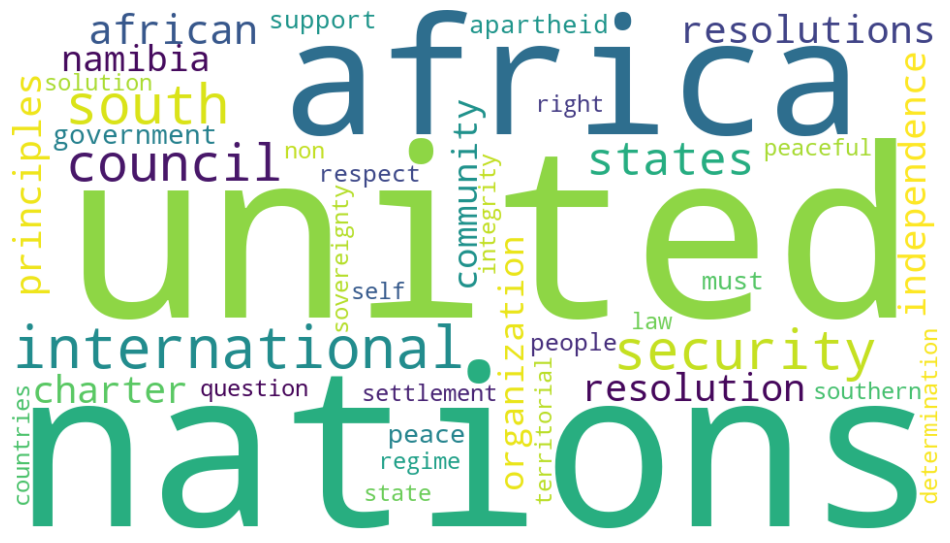

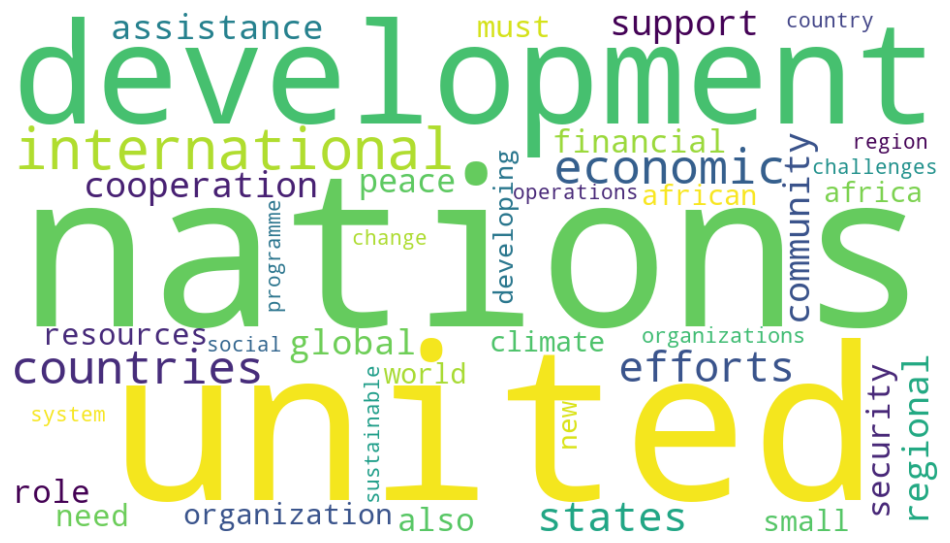

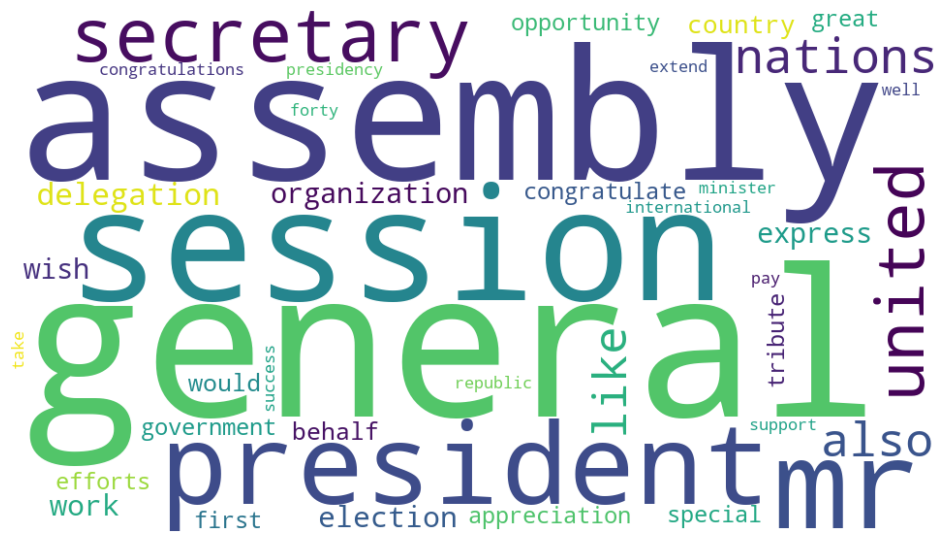

In [26]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

In [27]:
topic_names = []
voc = tfidf_para_vectorizer.vocabulary_
for topic in nmf_para_model.components_:
    important = topic.argsort()
    top_word = [word for word, index in voc.items() if index == important[-1]][0] + " " + [word for word, index in voc.items() if index == important[-2]][0]
    topic_names.append("Topic " + top_word)


# Separating Date By Year

In [28]:
from tqdm.auto import tqdm
import numpy as np
year_data = []
for year in tqdm(np.unique(np.unique(paragraph_df["year"]))):
    W_year = nmf_para_model.transform(tfidf_para_vectors[np.array(paragraph_df["year"] == year)])
    year_data.append([year] + list(W_year.sum(axis=0)/W_year.sum()*100.0))

  0%|          | 0/46 [00:00<?, ?it/s]

# TimeChart

<Axes: xlabel='year'>

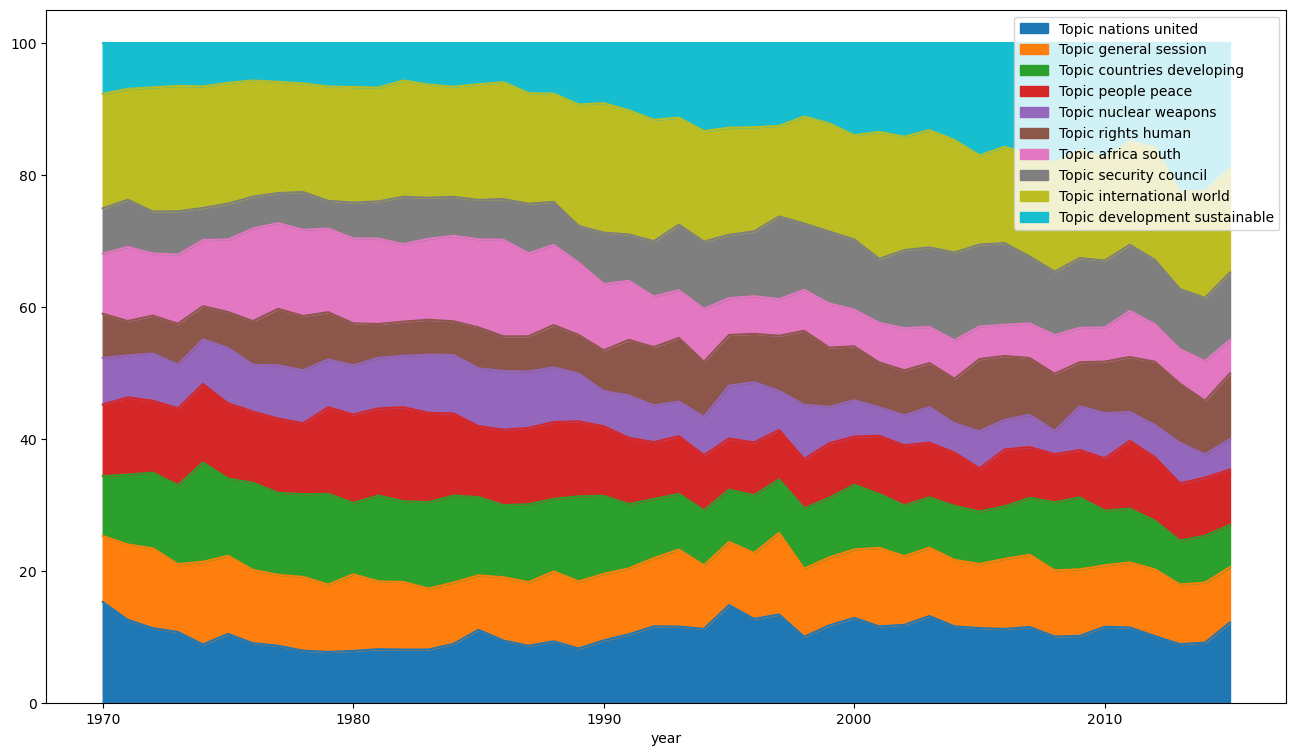

In [29]:
import matplotlib.pyplot as plt
df_year = pd.DataFrame(year_data, columns=["year"] + topic_names).set_index("year")
df_year.plot.area(figsize=(16,9))
